In [5]:
## COMP9517 Computer Vision Project 20T2
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

import torch
from torch import nn, optim
import torch.nn.functional as F

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

In [6]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.net = nn.Conv2d(1, 1, 5)
    
    def forward(self, x):
        """
        Forward pass through the network
        """
        return self.net(x)
    

def lossFunction():
    """
    TODO: Implement the Weighted Mean Square Error loss function as per ISBI-final paper
    Currently using Mean Square Error loss
    """
    return F.mse_loss

def train_net():
    """
    Train the network on data and save the model
    """
    device = torch.device("cpu")
    net = Network().to(device)
    optimiser = optim.Adam(net.parameters(), lr=0.001) # optimising using Adam algorithm
    criterion = lossFunction()
    
    # Iterate over a number of epochs on the data
    for epoch in range(10):
        # TODO: perform training step
        print(f"Epoch: {epoch+1}")
    
    torch.save(net.state_dict(), "./model.pth")
    print("Saved model")


train = input("Train Network? y/n\n> ")
if train.lower() == "y":
    train_net()

NameError: name 'nn' is not defined

In [7]:
def detect_DIC():
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        
        blurred = cv2.medianBlur(image, 21)
        
        denoised = cv2.fastNlMeansDenoising(blurred, h=3)        
        
        # adaptive normalization - see paper https://is.muni.cz/www/svoboda/ISBI-final.pdf
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(denoised)
        
        mj_filtered = meijering(cl1)
        mj_filtered = custom_thresh(mj_filtered)
        
        kernel = np.ones((4,4),np.uint8)

        eroded = cv2.erode(mj_filtered, kernel, iterations=1)

        thresh = cv2.threshold(eroded, 129, 255, cv2.THRESH_BINARY)[1]

        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        plt.gray()
        plt.imshow(image)
        plt.show()
        
        plt.imshow(blurred)
        plt.show()
        
        plt.imshow(denoised)
        plt.show()
        
        plt.imshow(cl1)
        plt.show()
        
        plt.imshow(mj_filtered)
        plt.show()
        
        plt.imshow(eroded)
        plt.show()
        
        plt.imshow(thresh, cmap='gray')
        plt.show()
        
        plt.imshow(ws_labels)
        plt.show()
        
        #break stops loop after one iteration for debugging
        break
    return

In [8]:
def detect_Fluo():
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        # Threshold at value of 129
        thresh = cv2.threshold(image, 129, 255, cv2.THRESH_BINARY)[1]
        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.gray()
        plt.imshow(thresh, cmap='gray')
        plt.show()
        plt.imshow(image)
        plt.show()
    return

def detect_PhC():
    for filename in fi_list('PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        thresh = cv2.threshold(image, 162, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((4,4),np.uint8)
        # Perform an erosion followed by dilation opening to remove noise
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        distance = ndi.distance_transform_edt(opening)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.imshow(image, cmap='gray')
        plt.show()
        plt.imshow(opening, cmap='gray')
        plt.show()
        plt.imshow(ws_labels, cmap='gray')
        plt.show()
    return

Choose a dataset.
1) DIC-C2DH-HeLa
2) Fluo-N2DL-HeLa
3) PhC-C2DL-PSC
> 1
DIC-C2DH-HeLa/Sequence 1/t000.tif


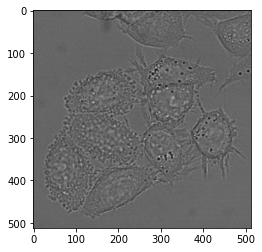

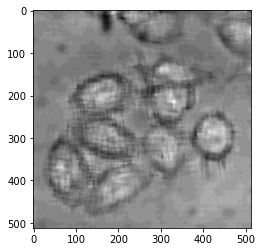

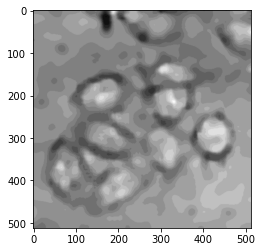

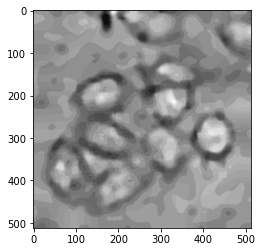

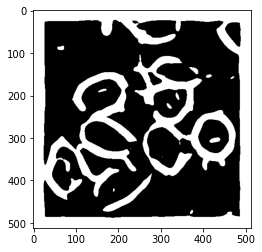

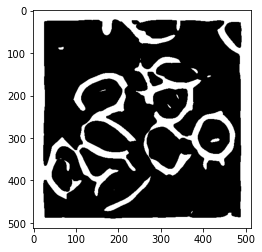

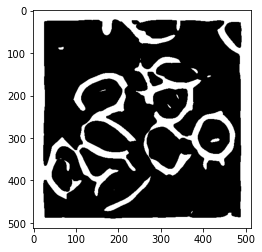

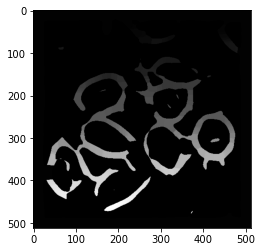

In [9]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()